# Computing initial and terminal states

In this tutorial, you will learn how to use the [GPCCAEstimator](https://cellrank.readthedocs.io/en/stable/api/cellrank.estimators.GPCCA.html) to...

- compute macrostates of cellular dynamics.
- visualize a coarse-grained transition matrix among macrostates.
- classify macrostates as initial, terminal or intermediate.

<div class="alert alert-info">
Important

If you use the `GPCCAEstimator` in your research, plese do not forget to cite both CellRank as well as the original GPCCA papers: <cite cite-date="reuter:18,reuter:19"></cite>. See ["how to cite us"](https://cellrank.readthedocs.io/en/stable/citing.html) for more info. 

</div>

This tutorial does not depend on the kernel you used to compute a cell-cell transiton matrix. No matter whether you used the [VelocityKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.VelocityKernel.html), the [PseudotimeKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.PseudotimeKernel.html), the [CytoTRACEKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.CytoTRACEKernel.html), or any other CellRank kernel to compute transition probabilities, you may always follow the steps outlined in this tutorial to compute initial and terminal states. This is explained in more detail in our [getting started](https://cellrank.readthedocs.io/en/stable/getting_started.html) tutorial and summarized in the figure below. 

<img src="_static/img/cellrank_overview.png" width="800" alt="The GPCCA estimator is independent of the kernel you used to compute a cell-cell transition matrix. ">

**Fig** | CellRank is a modular framework where every kernel may be used to compute initial and terminal states.

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of pancreas development at embyonic day E15.5 <cite data-cite="bastidas-ponce:19"></cite>. We used this dataset in our [cellrank meets rna velocity tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_velocity.html) to compute a cell-cell transition matrix using the `VelocityKernel`; this tutorial builds on the transition matrix computed there. 

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset for which you computed a cell-cell transition matrix using any CellRank kernel. For each kernel, there exist individual tutorials that teach you how to use them. 

</div>

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/initial_terminal_states.ipynb).

## Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

from scipy.stats import ttest_ind
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

REMOVE LATER

In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.5.1+g6150f029, on 2023-02-23 11:25.


In [4]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

Read AnnData object from disk (or download) and reconstruct a [VelocityKernel](https://cellrank.readthedocs.io/en/latest/api/_autosummary/kernels/cellrank.kernels.VelocityKernel.html#) from it. 

In [5]:
adata = sc.read('datasets/ML_2022-06-23_pancreas_with_transition_matrix.h5ad')

vk = cr.kernels.VelocityKernel.from_adata(adata, key='T_fwd')
vk

VelocityKernel[n=2531, model='deterministic', similarity='correlation', softmax_scale=3.797]

<div class="alert alert-info">
Important

The method `from_adata()` allows you to reconstruct a CellRank kernel from an [AnnData](https://anndata.readthedocs.io/en/latest/) object. When you use a kernel to compute a transition matrix, this matrix, as well as a few informations about the computation, are written to the underlying AnnData object. This makes it easy to write and read kernels from disk via the associated AnnData object. 

</div>

As a reminder, below is a UMAP <cite data-cite="mcinnes:18,becht:19"></cite> with cluster labels of this dataset <cite data-cite="bastidas-ponce:19"></cite>. In this tutorial, we will automatically identify the initial and terminal states. 

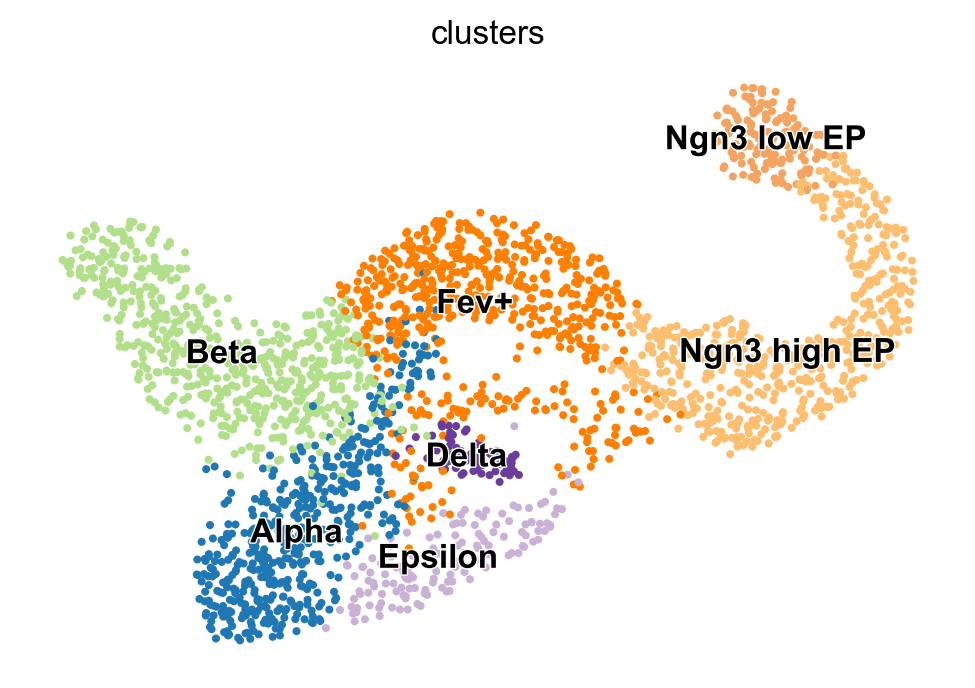

In [6]:
scv.pl.scatter(adata)

## Initialize an estimator 

Estimators allow you to analyze cell-state dynamics in CellRank. We initialize a `GPCCAEstimator` here by passing the kernel object <cite data-cite="reuter:18,reuter:19"></cite>. This works for *every* kernel. 

In [7]:
g = cr.estimators.GPCCA(vk)
print(g)

GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]


We use the `GPCCAEstimator` below to compute initial & terminal states; it may further be used to compute fate probabilities as we explain in the [fate probabilities & driver genes tutorial](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/fate_probabilities.html). 

<div class="alert alert-info">
Important

You can interact with the `GPCCAEstimator` in two ways:
- via the `fit()` and `predict()` methods; this is very convenient but offers less control. 
- low-level, by computing the schur decomposition, the macrostates, etc. While there are a few more method cells involved here, it offers you more control. 
    
We'll demonstrate both modes in this tutorial. 

</div>

## Basic usage: `fit()` and `predict()`

We fit the estimator; this computes a [Schur decompsition](https://en.wikipedia.org/wiki/Schur_decomposition) and uses the GPCCA algorithm <cite data-cite="reuter:18,reuter:19"></cite> as implemented in [pyGPCCA](https://pygpcca.readthedocs.io/en/latest/) to compute macrostates by maximizing for metastability <cite data-cite="reuter:22"></cite>. Macrostates may contain initial, terminal and intermediate states of cellular dynamics.  

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[11]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Calculating minChi criterion in interval `[4, 12]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


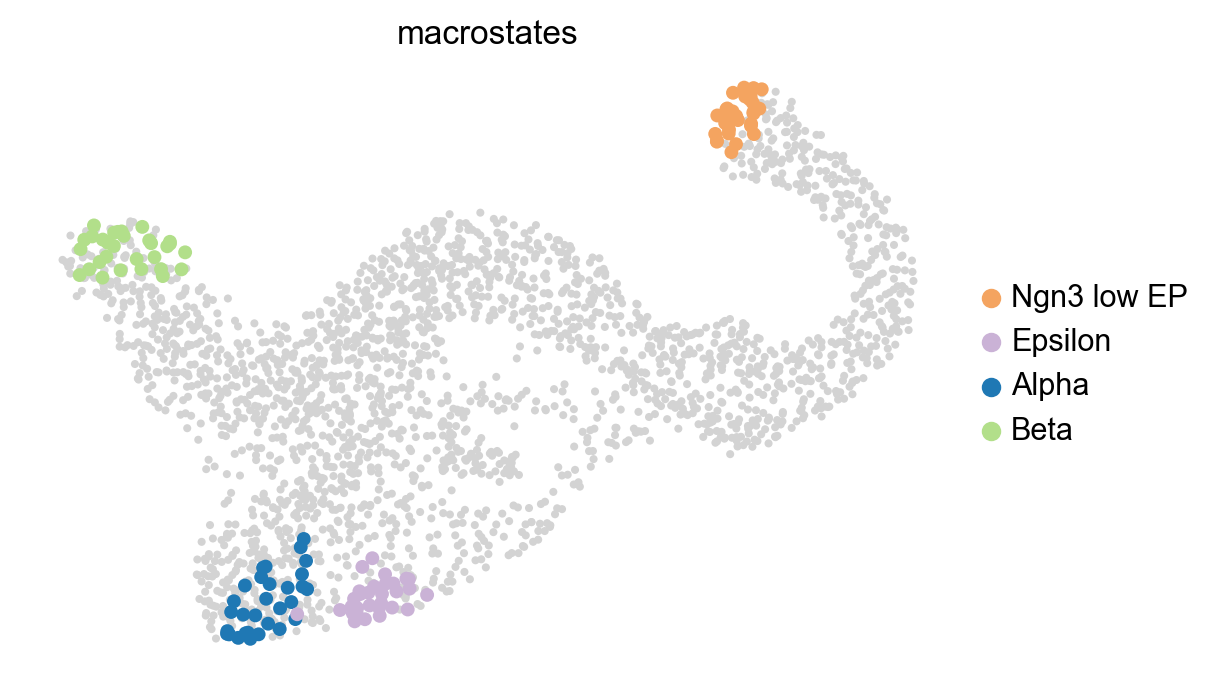

In [18]:
g.fit(cluster_key='clusters', n_states=[4, 12])
g.plot_macrostates(which="macro", discrete=True, legend_loc='right', s=100)

Using `n_states=[a, b]`, we told the algorithm to scan this interval for the optimal number of macrostates. It identified 4 macrostates which we show above in the UMAP. For each macrostate, we display the `n_cells` cells most strongly associated with it. Each macrostate was automatically assigned a label by associating it with the cluster labels stored in `adata.obs['clusters']`; this is controled using `cluster_key`. 

You can check out the [pyGPCCA documentation](https://pygpcca.readthedocs.io/en/latest/index.html) for more infos on the macrostate computation. 

<div class="alert alert-warning">
Warning

Make sure to have the scientific computing libraries [PETSc](https://petsc.org/release/) and [SLEPc](https://slepc.upv.es/) installed for maximum performance. On most machines, this is strongly recommended if your datasets consists of over **10k cells**. See our [installation instructions](https://cellrank.readthedocs.io/en/stable/installation.html). 

</div>

In the next step, we use the `predict_terminal_states()` method to identify terminal macrostates. 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


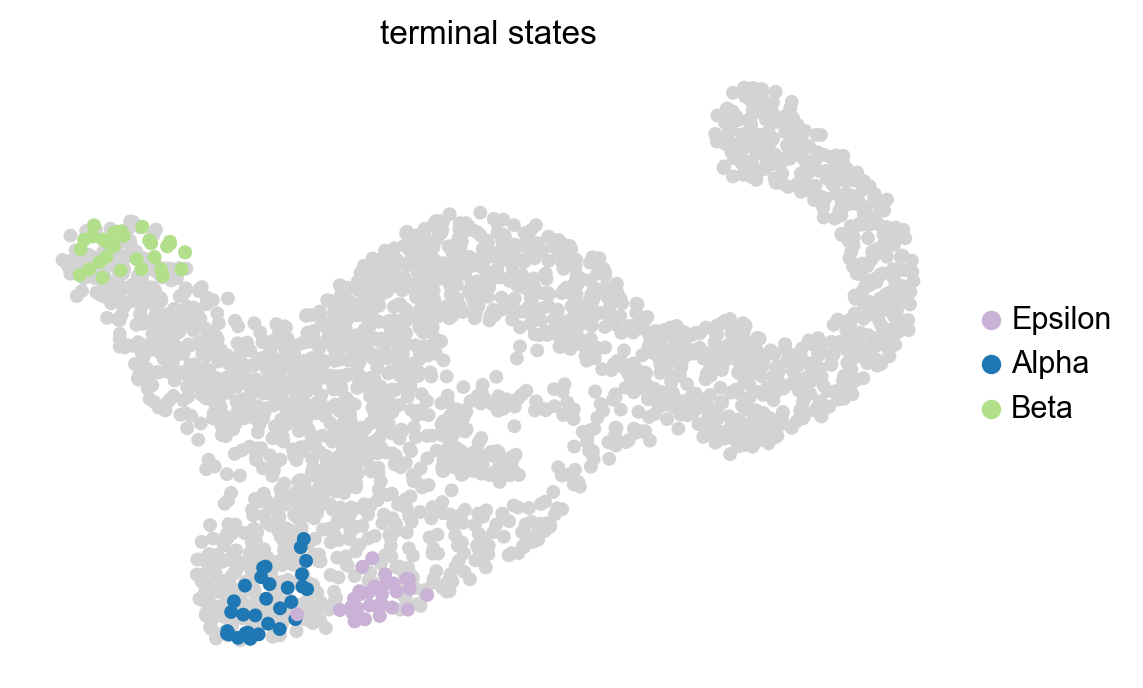

In [24]:
g.predict_terminal_states()
g.plot_macrostates(which='terminal', legend_loc='right', size=100)

We automatically identified the Alpha, Beta and Epsilon states as terminal. While the plot above just shows the cells most confidently assigned to each terminal state, we can also plot the underlying continious distribution for each macrostate.

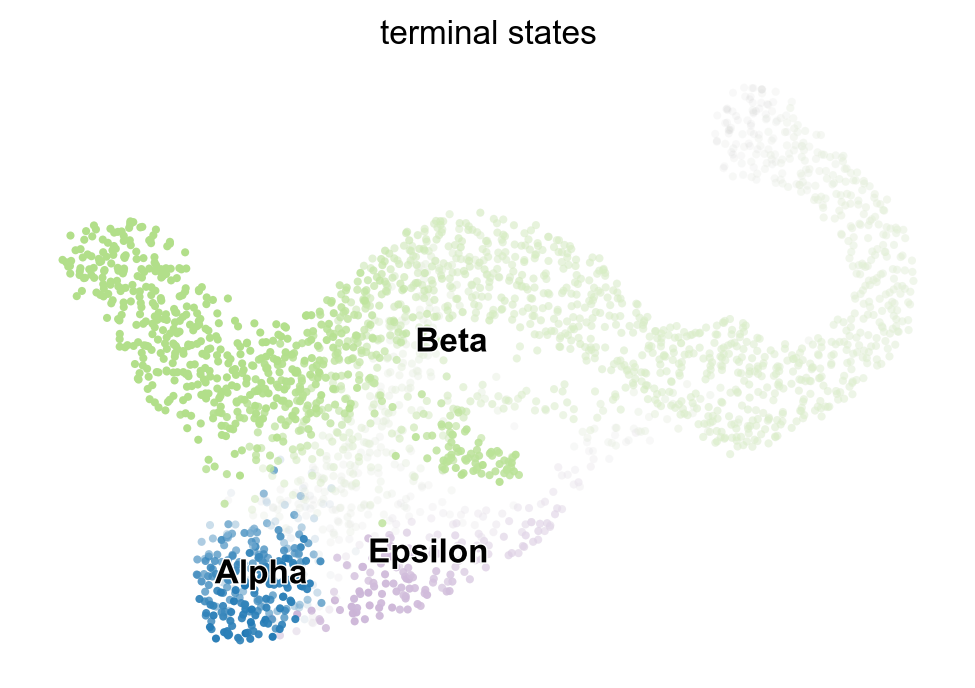

In [25]:
g.plot_macrostates(which='terminal', discrete=False)

Each cell is colored according to the terminal state it most likely belongs to; color intensity reflects uncertainty in the assignment.

<div class="alert alert-warning">
Warning

These values should **not** be confused with fate probabilities, they reflect our confidence in assigning a cell to a terminal state, but they don't tell us how likely a cell is to *reach* this terminal state. We demonstrate the computation of fate probabilities in the [fate probabilities & driver genes tutorial](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/fate_probabilities.html). 

</div>

We can identify initial states in a parallel manner:

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


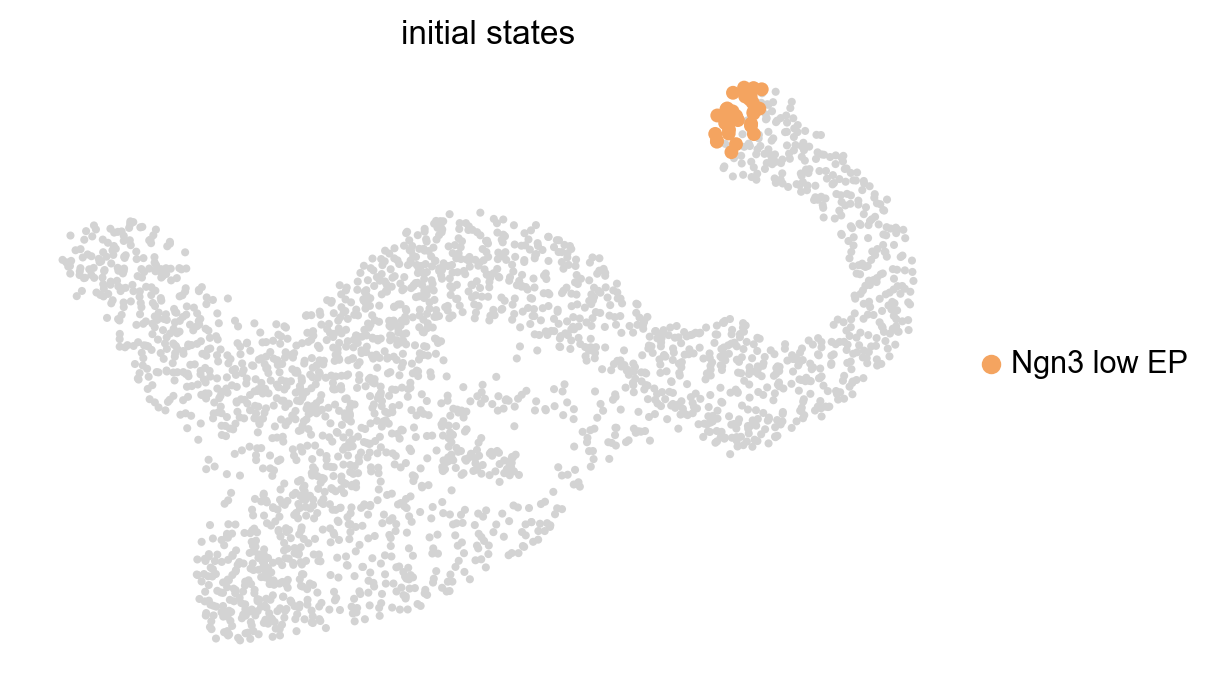

In [26]:
g.predict_initial_states()
g.plot_macrostates(which='initial', legend_loc='right', s=100)

This automatically identified the Ngn3 low EP state as initial, which is correct! Macrostates, and their classification as initial or terminal, is written to the GPCCA estimator object and can be inspected conveniently:

In [27]:
g

GPCCA[kernel=VelocityKernel[n=2531], initial_states=['Ngn3 low EP'], terminal_states=['Alpha', 'Beta', 'Epsilon']]

We can visually confirm our terminal state identification by comparing with well-known mature cell-type markers *Ins1* and *Ins2* for Beta cells, *Gcg* for Alpha cells and *Ghrl* for epsilon cells. To confirm our inintial state identification, we visualize Ductal cell markers *Sox9*, *Anxa2* and *Bicc1*. 

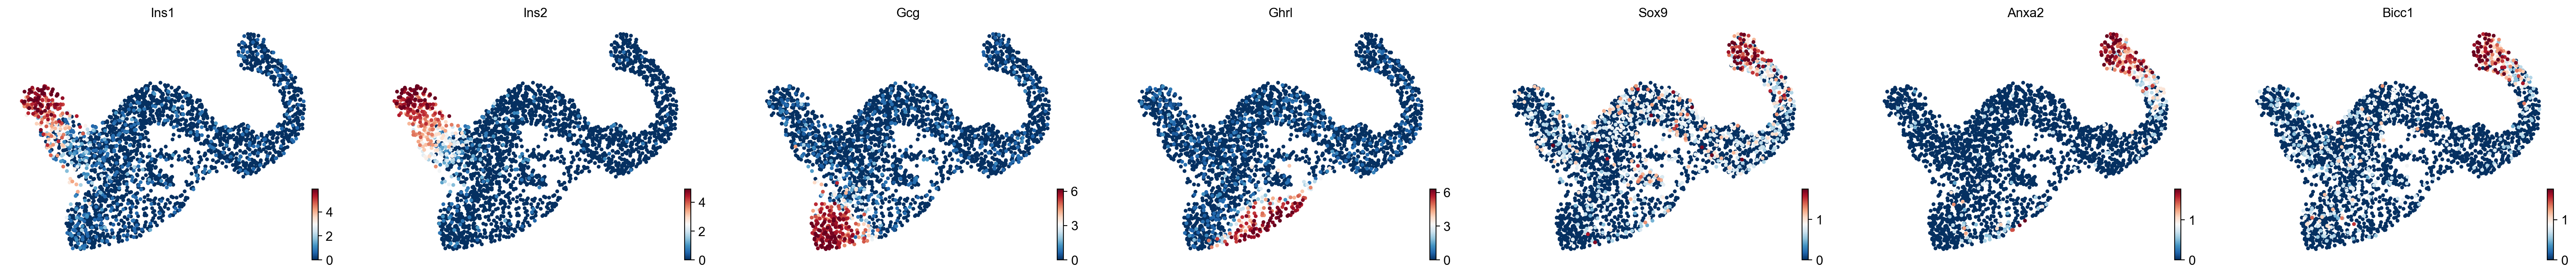

In [12]:
scv.pl.scatter(adata, c=['Ins1', 'Ins2', 'Gcg', 'Ghrl', 'Sox9', 'Anxa2', 'Bicc1'], size=50, perc=[0, 99])

Visually, these marker genes agree well with automatically identified initial- and terminal states. To make this a bit more quantitative, let's check whether our *terminal* Beta cells express *Ins1* at higher levels compared to other (non-terminal) Beta cells

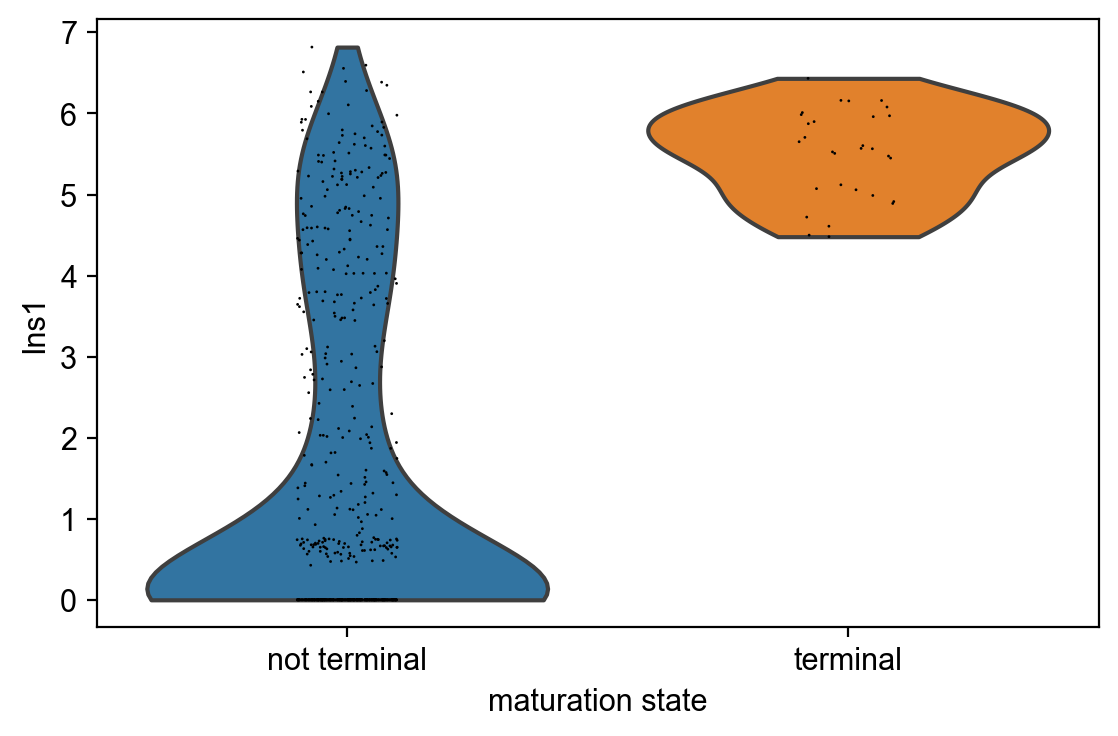

Ttest_indResult(statistic=16.823558104312575, pvalue=1.041101302205943e-33)

In [15]:
# subset to just Beta cells
bdata = adata[adata.obs['clusters'] == 'Beta'].copy()

# create an annotation for terminal vs. not-terminal
bdata.obs['maturation_state'] = np.where(bdata.obs['term_states_fwd'] == 'Beta', 'terminal', 'not terminal')

# show distribution in violin plot
sc.pl.violin(bdata, keys=['Ins1'], groupby='maturation_state')

# use a simple t-test to quantify how different the two distributions are
a = bdata[bdata.obs['maturation_state'] == 'terminal', 'Ins1'].X.data
b = bdata[bdata.obs['maturation_state'] == 'not terminal', 'Ins1'].X.data
ttest_ind(a, b, equal_var=False)

This looks promising, the cells we automatically identified as *terminal* Beta cells express the maturation marker Ins1 at significantly higher levels compared to other Beta cells. This can be a helpful technique to confirm automatic initial and terminal state identification in settings where prior knowlege is available. 

The classification of macrostates as initial or terminal is based on the coarse grained transition matrix, which we show below. 

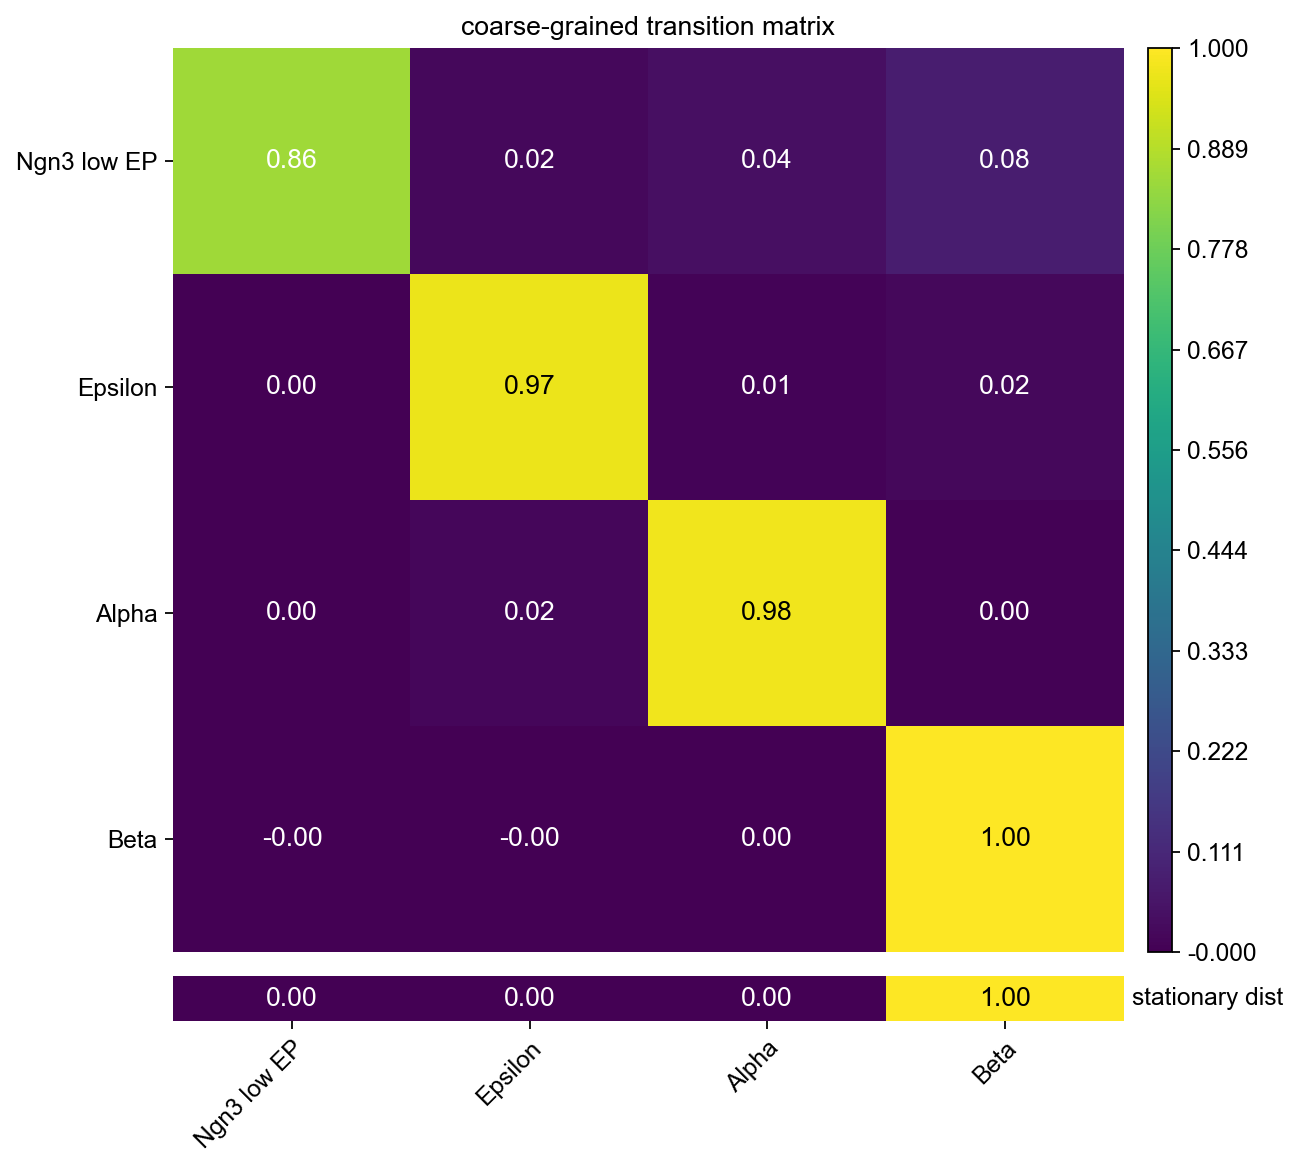

In [16]:
g.plot_coarse_T()

This transition matrix aggregates the single-cell Markov chain to a macrostate-level Markov chain. Entries in this matrix tell us how likely macrostates are to transition into one-another. We identify initial and terminal states based on the following criteria:

- **terminal states** are very stable (large value on the diagonal). They can have incoming probability mass, but almost no outgoing probabilits mass. 
- **initial states** are less stable (smaller values on the diagonal and in the coarse-grained stationary distribution). They can have outgoing, but almost no incoming probability mass. 
- **intermediate states** are just all remaining states which we classified neither as terminal nor as initial. 

Note that the automatic identification does not always work perfectly. For example, we did not automaticall identify the terminal Delta cell population in our analysis above. For this reason, we'll next explore the low-level mode to interact with the GPCCA estimator which offers a bit more control and supervision to bring in any prior knowledge that you might have about the biological system. 

## Advanced usage

Let's start with a new estimator object. 

In [17]:
g2 = cr.estimators.GPCCA(vk)
print(g2)

GPCCA[kernel=VelocityKernel[n=2531], terminal_states=None, macrostates=None]


The computation of macrostates is based on the real [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition) - essentially a generalization of the eigendecomposition. For non-symmetric transition matrices, as in our case, the eigendecomposition in general yields complex eigenvalues and eigenvectors, which are difficult to interpret. Thus, we revert to the real Schur decomposition <cite data-cite="reuter:18,reuter:19"></cite>. 

Below, we also plot the top eigenvalues (real part only) we identified in blue (real eigenvalue) and orange (complex eigenvalue). For real matrices, complex eigenvalues always appear in pairs of complex conjugates. 

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[11, 16, 19]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


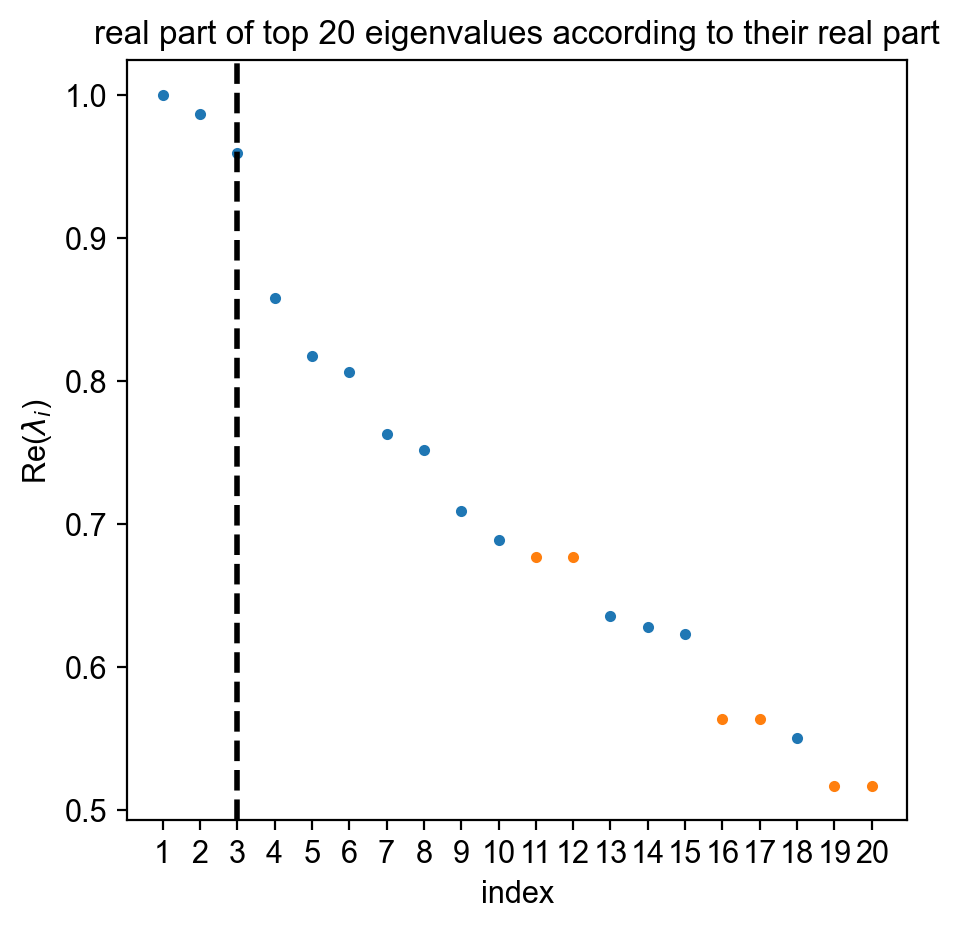

In [18]:
g2.compute_schur()
g2.plot_spectrum(real_only=True)

Using the real Schur decomposition, we compute macrostates. In the plot above, the estimator automatically suggested a number of states to use (horizontal line); however, we will ignore that and compute a few more states to have a chance at identifying the Delta cell population. 

Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)


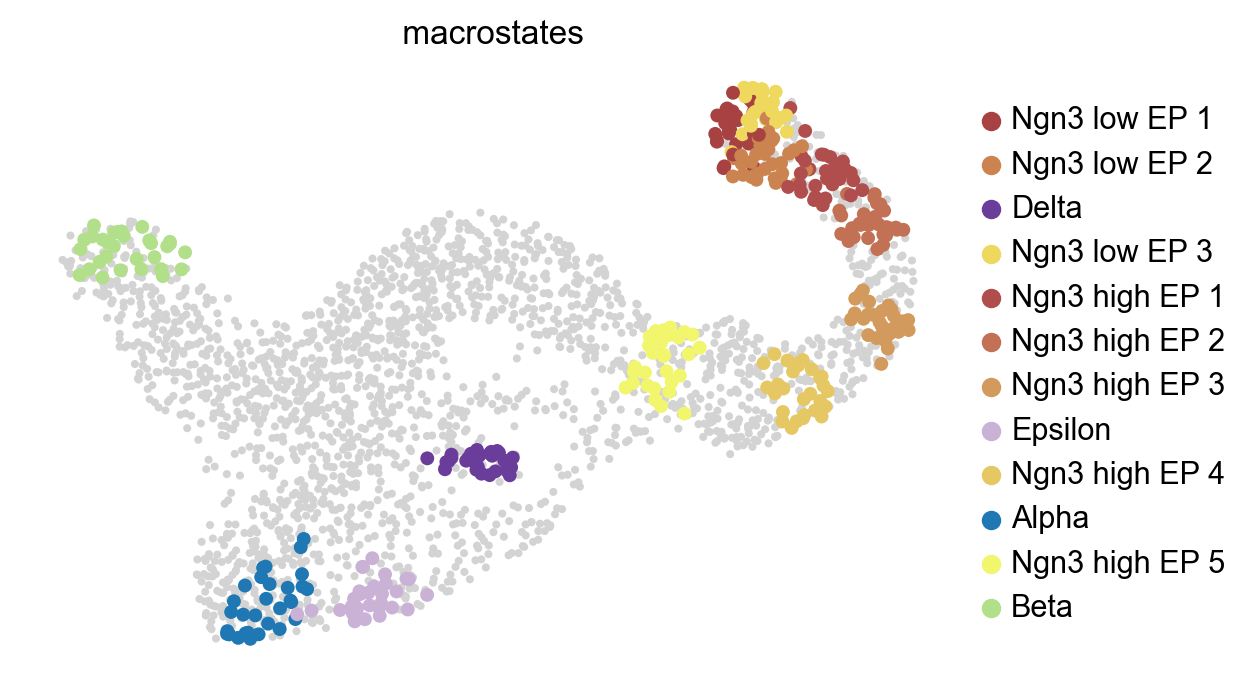

In [19]:
g2.compute_macrostates(n_states=12, cluster_key='clusters')
g2.plot_macrostates(discrete=True, legend_loc='right', s=100)

Nice! We now have macrostates for Alpha, Beta, Epsilon and Delta populations, besides a few progenitor populations. We assign one label per macrostate based on the underlying `'clusters'` annotation; however, that does not imply that all cells within one macrostate are from the same underlying cluster as we use majority voting. We can visualize the relationship between clusters and macrostates; we show below the distribution over cluster membership for each of the cells most confidently assigned to a certain macrostates

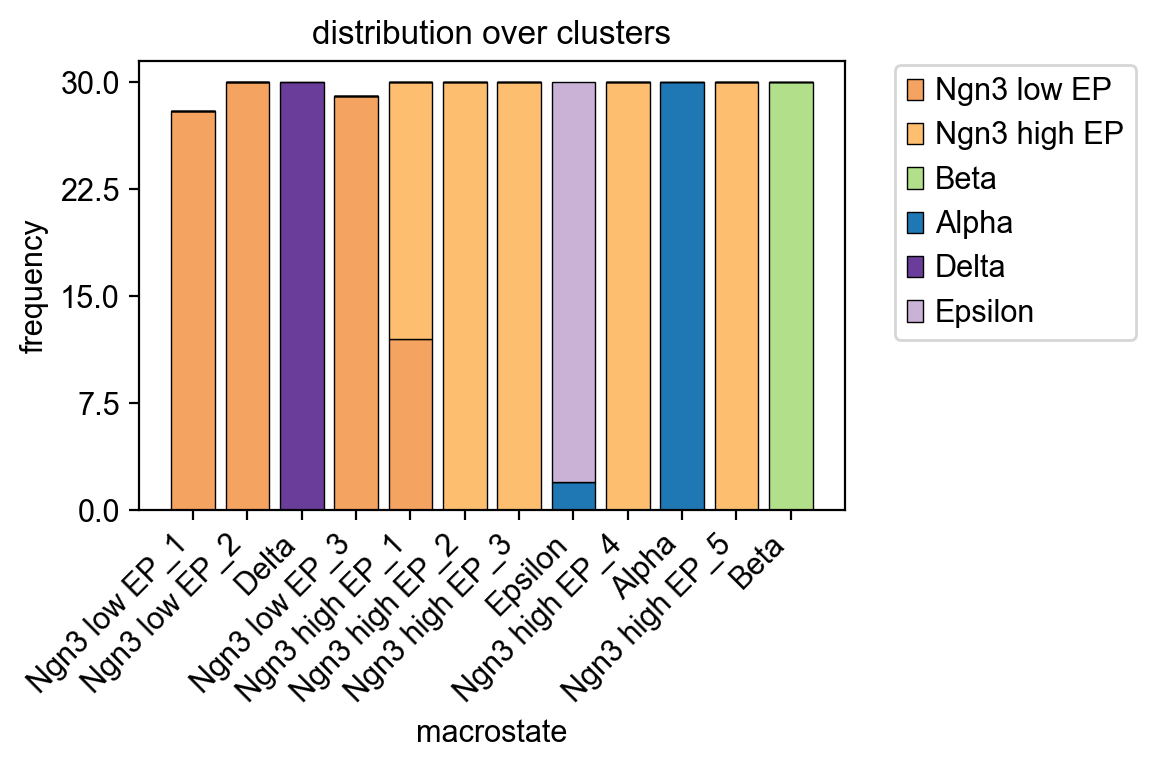

In [20]:
g2.plot_macrostate_composition(key='clusters')

With some exceptions, most macrostates recruit their top-cells from a single underlying cluster. This plotting function works for any `.obs`-level covariate and can be useful when we have experimental time labels as we expect more mature states to compe from later time points. 

To get an idea of how these macrostates are related, we plot the coarse-grained transition matrix. 

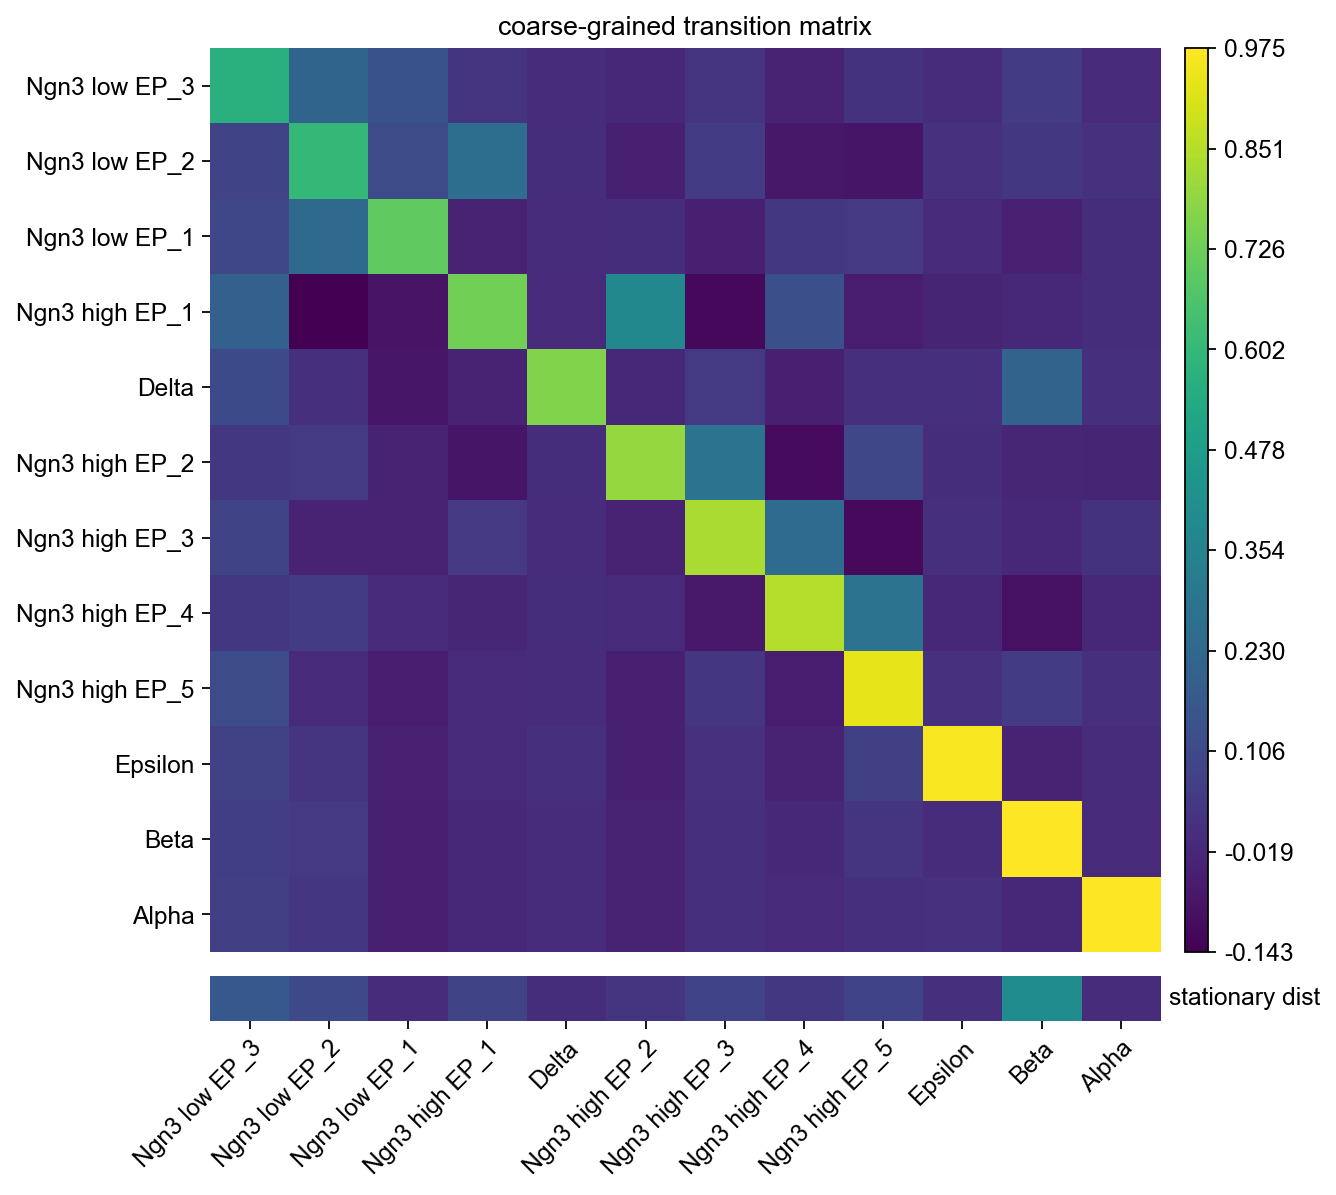

In [21]:
g2.plot_coarse_T(annotate=False)

By default, macrostates are ordered according to their diagonal value, increasing from left to right. The diagonal value is a proxy for a states *metastability*, i.e. the probability of leaving the state once entered. While the Epsilon, Alpha and Beta states have high diagonal values, Delta cells have a low value becasue they are predicted to transition into Beta cells (check the corresponding matrix element). 

Let's try automatic terminal state identification. 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


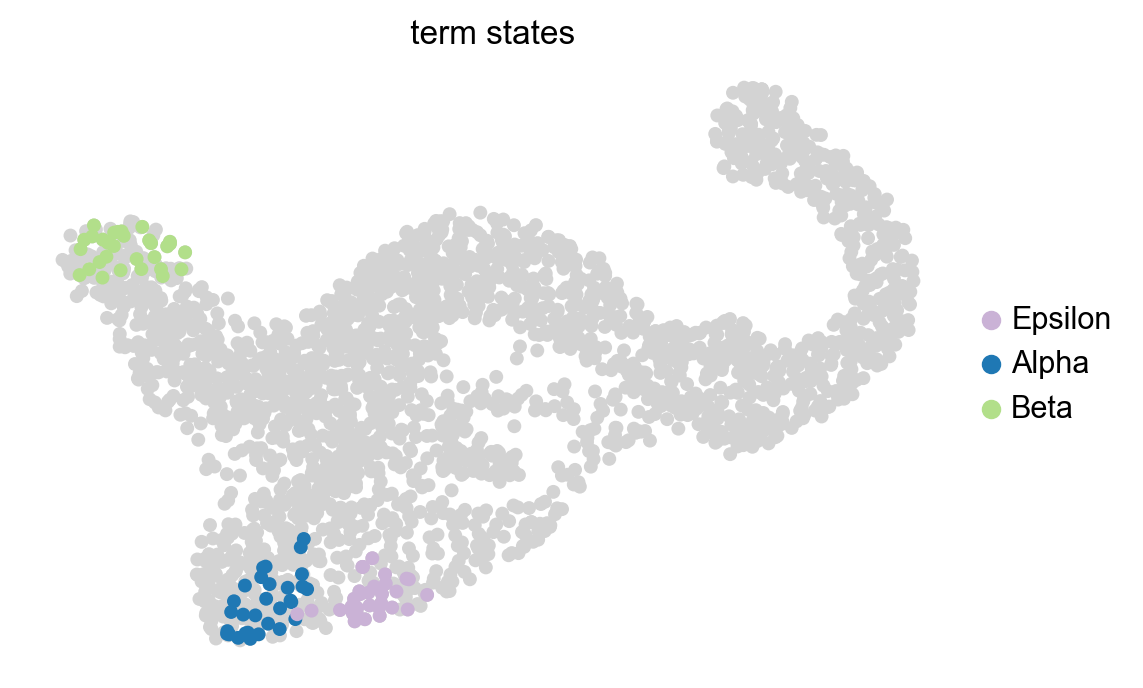

In [22]:
g2.predict(which='terminal')
g2.plot_states(which='terminal', legend_loc='right', size=100)

Besides many more macrostates being present now, this consistently identified the same three terminal states as before. However, we still did not catch the Delta cells! If we want to compute fate probabilities towards them later on, we need to annotate them as a terminal state. Luckily, this can be done semi-automatically as well:

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


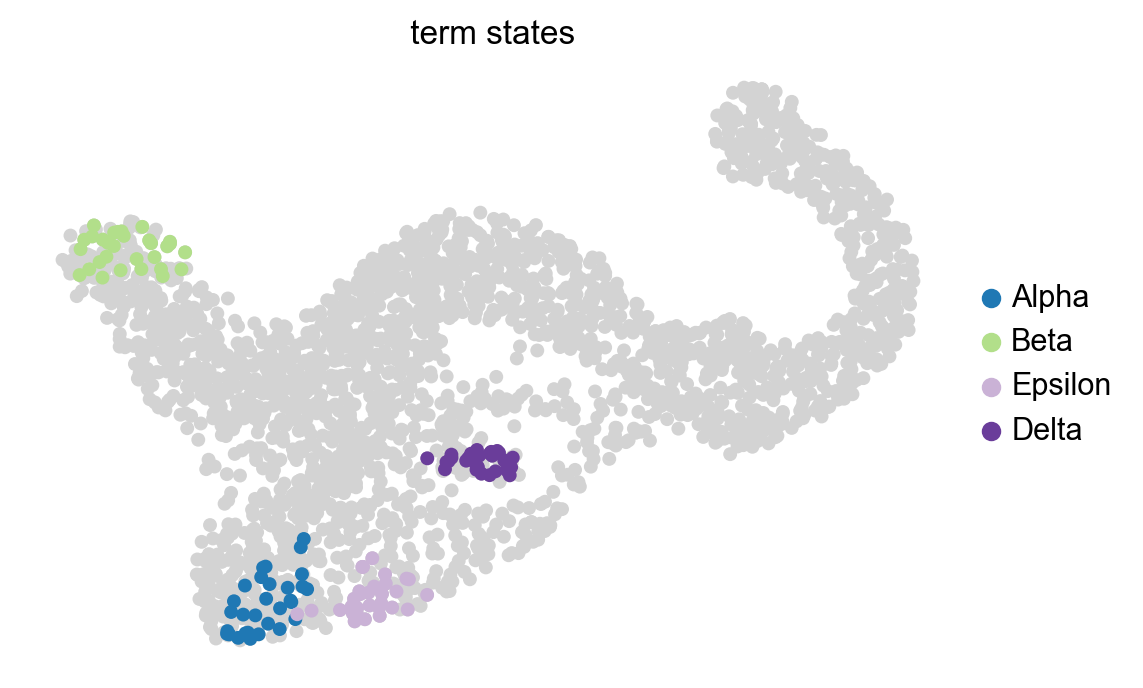

In [23]:
g2.set_states_from_macrostates(which='terminal', names=['Alpha', 'Beta', 'Epsilon', 'Delta'])
g2.plot_states(which='terminal', legend_loc='right', size=100)

We call this semi-automatic terminal state identification as we manually pass the macrostates we would like to select, however, the actual macrostates are computed automatically. Semi-automatic terminal state identification can be combined with automatic initial state identification (or the other way round, any combination works).  

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


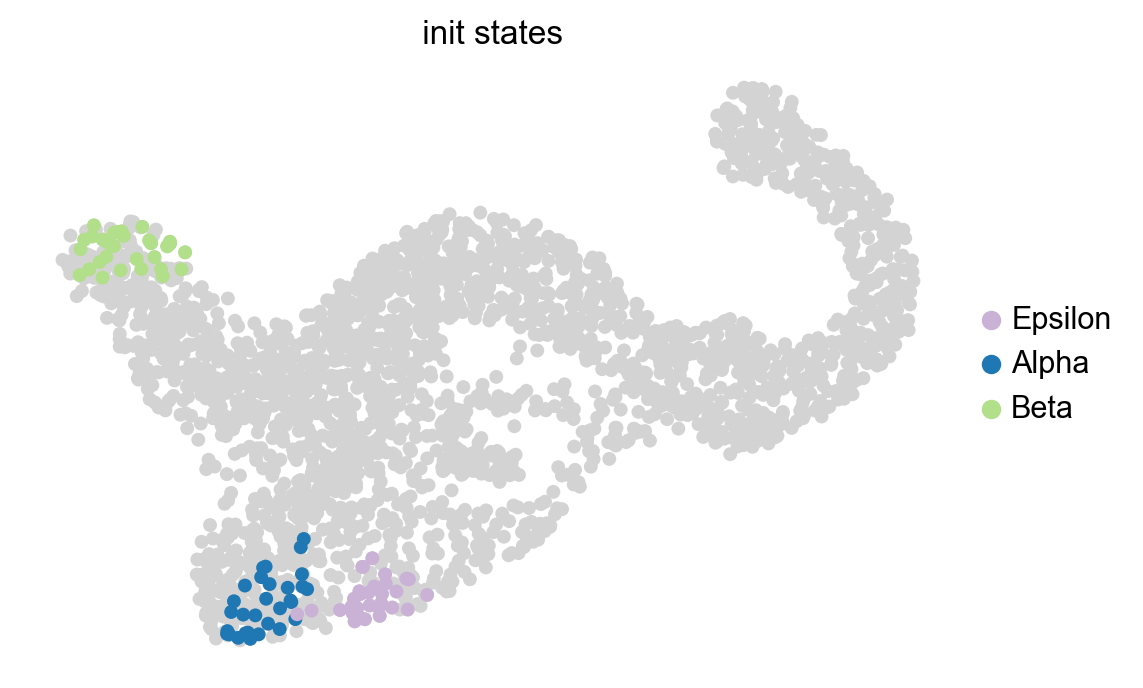

In [24]:
g2.predict(which='initial')
g2.plot_states(which='initial', legend_loc='right', size=100)

How can we check whether this is really the correct initial state? In this case, we have prior knowledge that we can use: we know that the initial state should be high for a number of ductal-cell markers. So let's use these markers to compute a score that we can visualize across macrostates to confirm that we have the correct one. 

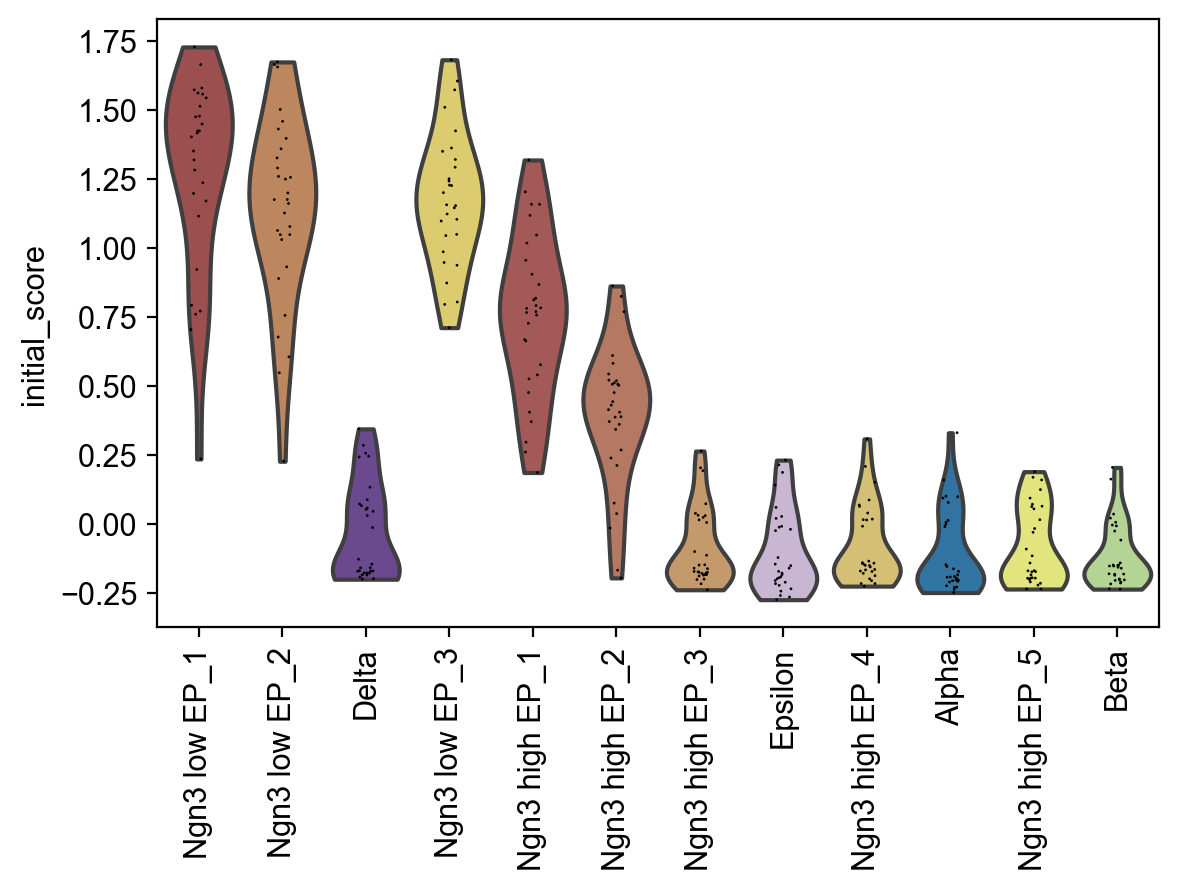

In [25]:
# compute a score in scanpy by aggregating across a few ductal markers
sc.tl.score_genes(adata, gene_list=['Bicc1', 'Sox9', 'Anxa2'], score_name='initial_score')

# write macrostates to AnnData
adata.obs['macrostates'] = g2.macrostates
adata.uns['macrostates_colors'] = g2.macrostates_memberships.colors

# visualize via heatmaps
sc.pl.violin(adata, keys='initial_score', groupby='macrostates', rotation=90)

In [28]:
g2.compute_absorption_probabilities()

Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.absorption_probabilities`
    Finish (0:00:00)


In fact, the `'Ngn3 low EP_1'` state scores highest, confirming out automatic identification of this state as initial. The same strategy can be used to confirm terminal state identification, or to guide semi-automatic identification in the first place. To conclude this tutorial, we jointly plot all initial and terminal states we identified. 

In [26]:
g2.plot_states(which='initial_and_terminal', legend_loc='right', size=100)

ValueError: Expected `which` to be either `'initial'` or `'terminal'`, found `'initial_and_terminal'`.

## What's next? 

In this tutorial, you learned how to use CellRank's [GPCCA estimator](https://cellrank.readthedocs.io/en/latest/api/_autosummary/estimators/cellrank.estimators.GPCCA.html) to compute initial and terminal states of cellular dynamics. For the next steps, we recommend...

- going through the [fate probabilities & driver genes tutorial](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/fate_probabilities.html) to learn how to quantify cellular fate commitment. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- taking a look at the original GPCCA publications to get familiar with the maths behind these computations <cite data-cite="reuter:18,reuter:19"></cite>. 

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 

## Package versions

In [27]:
cr.logging.print_versions()

cellrank==1.5.1+g1fda0304.d20220729 scanpy==1.9.1 anndata==0.8.0 numpy==1.22.0 numba==0.56.0 scipy==1.8.1 pandas==1.4.3 pygpcca==1.0.3 scikit-learn==1.1.1 statsmodels==0.13.2 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2
